In [1]:
from models import *

## Chose model
model_class = PLSegmentationUnetModel
model_path = 'saved_models/bigger_model_twice_trained.model'

In [2]:
## Load model
model = model_class.load(model_path)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')


Model loaded from: 'saved_models/bigger_model_twice_trained.model'
Trainable parameters: 31040897


In [3]:
## Synthetic dataset
from models.psf import GuassionPSF
from simulation.grain_PL_simulation import TrainingDataSimulationOptions
from torch_utils.dataset import GeneratedPLOutlineDataset
from torch.utils.data import Dataset

from torchvision import transforms

from torch_utils.transform import BackgroundRemovalNormalize, SkipFrames

def get_training_data(length: int = 20) -> Dataset:
    psf = GuassionPSF(2.5)

    factor = 2
    options = TrainingDataSimulationOptions(
        grid_size=256 // factor,
        min_grains=1000 // (2 * factor * factor),
        max_grains=1400 // (2 * factor * factor),
        min_noise=0.05 ,
        max_noise=0.12,
        sample_rate=10,
        seconds=10, ## Decides how many frames each test samples has: total frames = sample_rate * seconds
        min_blinker_transition=0.04,
        max_blinker_transition=0.1,
        min_base_counts=6000,
        max_base_counts=12000,
        min_hole_chance=0.01,
        max_hole_chance=0.1,
        min_boundary_dimish=0,    
        max_boundary_dimish=1.0,
        psf=psf,
        label_scaling=2
    )

    generated_dataset = GeneratedPLOutlineDataset(length=20, 
                                              sim_options=options, 
                                              transforms=transforms.Compose([
                                                BackgroundRemovalNormalize(),
                                                SkipFrames(skip=3),
                                              ]))

    return generated_dataset

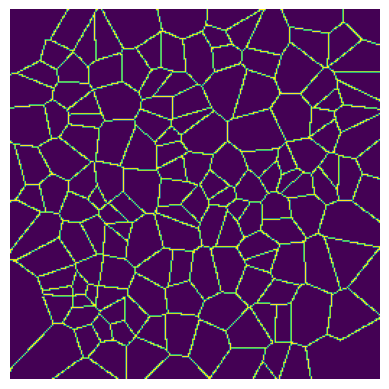

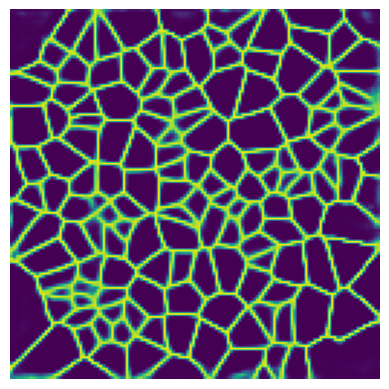

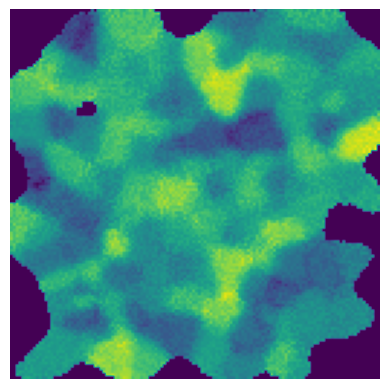

In [12]:
import torch

from torch_utils.transform import NormalizeIntensityTrace 

def inference(model: torch.nn.Module, input: torch.Tensor, apply_transforms: bool = False) -> torch.Tensor:
    if apply_transforms:
        f = transforms.Compose(
            [NormalizeIntensityTrace(),
            SkipFrames(skip=3),]
        )
        input = f(input)
    
    with torch.no_grad():
        ## Video data has shape (frames, width, height)
        ## Expected input: (batches, frames, channels, width, height)
        input = input.unsqueeze(0).unsqueeze(2)

        output = model.forward(input, inference=True)

        return output.squeeze(0).squeeze(0)


import matplotlib.pyplot as plt

dataset = get_training_data(20)
video, label = dataset.__getitem__(0)

output = inference(model, video).squeeze(0).squeeze(0)

plt.imshow(label)
plt.axis('off')

plt.subplots()

plt.imshow(output)
plt.axis('off')

plt.subplots()

plt.axis('off')
plt.imshow(video[0])

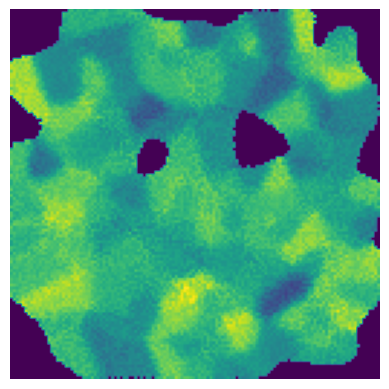

In [8]:
video_frame = video[20,:,:]

plt.axis('off')
plt.imshow(video_frame)

In [9]:
## Load some real data
from data_utils.tiff import tiff_to_array

data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air no enhancement mv4.tif')

SyntaxError: unterminated string literal (detected at line 4) (1202593680.py, line 4)

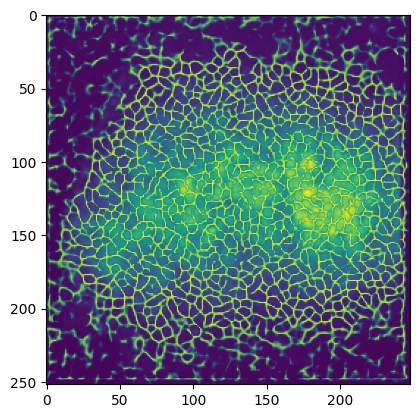

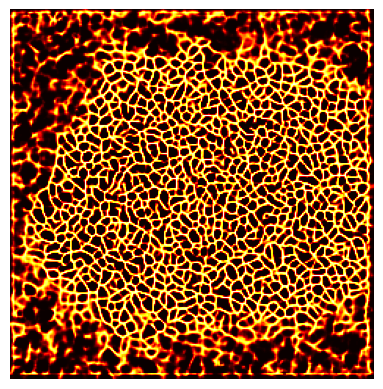

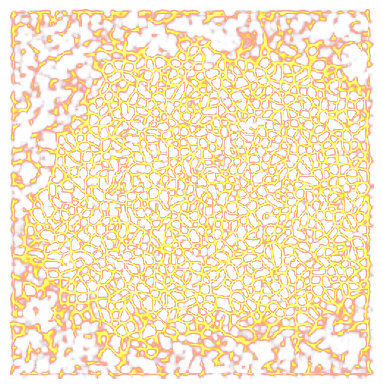

In [10]:
num_frames = 150


sample_video = data[:num_frames, :, :]
first_frame = sample_video[0]

model_output = inference(model, sample_video, apply_transforms=True)

plt.subplots()

plt.imshow(first_frame)
plt.imshow(model_output, alpha=model_output)

plt.subplots()

plt.imshow(model_output, cmap='hot')
plt.axis('off')

plt.subplots()

plt.imshow(model_output, alpha=model_output, cmap='hot')
plt.axis('off')
plt.savefig('test_transparant_map.png', transparent=True, dpi=300)


In [48]:
from data_utils.gif import write_gif

frames = data[:200]
write_gif('test_small.gif', frames, 20)